In [10]:
import pandas as pd
import numpy as np
import dfhealth as dh 
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
import matplotlib.pyplot as plt 
import seaborn as sns 
import mlflow 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
import joblib  # Model persistence
import pickle

# API + Deployment
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel
import uvicorn

# Docker + Containerization
import docker
from docker import client


In [11]:
#LOAD PANDAS DATA FRAME 
df = pd.read_csv('Fraud Detection Dataset.csv')

In [12]:
df.head() # First 5 rows


,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent
0,T1,4174,1292.76,ATM Withdrawal,16.0,Tablet,San Francisco,0,119,13,Debit Card,0
1,T2,4507,1554.58,ATM Withdrawal,13.0,Mobile,New York,4,79,3,Credit Card,0
2,T3,1860,2395.02,ATM Withdrawal,NaN,Mobile,NaN,3,115,9,NaN,0
3,T4,2294,100.10,Bill Payment,15.0,Desktop,Chicago,4,3,4,UPI,0
4,T5,2130,1490.50,POS Payment,19.0,Mobile,San Francisco,2,57,7,Credit Card,0


In [13]:
# investigate data frame for issues using health check 
report = dh.health_check(df)
report.print()

🏥 Data Health Report: 4 issues found

Summary:
  - WARN: 3
  - INFO: 1

--- WARNS ---
• D001 (Duplicate Rows): 881 duplicate rows detected
  └─ Suggested Fix: Use df.drop_duplicates() to remove redundant rows
• I001 (ID Integrity): Column 'Transaction_ID' looks like an ID but contains non-unique values
  └─ Column: Transaction_ID
  └─ Suggested Fix: Check if duplicates in ID column are intentional; IDs should usually be unique
• I001 (ID Integrity): Column 'User_ID' looks like an ID but contains non-unique values
  └─ Column: User_ID
  └─ Suggested Fix: Check if duplicates in ID column are intentional; IDs should usually be unique

--- INFOS ---
• O001 (Extreme Outliers): Column 'Transaction_Amount' has 508 extreme outliers
  └─ Column: Transaction_Amount
  └─ Suggested Fix: Consider investigating values outside of [3*IQR] range

📖 Code Reference:
  D001: Duplicate Rows
  I001: ID Integrity
  O001: Extreme Outliers


In [14]:
# lets drop the duplicated rows 
df.drop_duplicates(inplace=True)

In [15]:
#lets review data types 
df.dtypes

Transaction_ID                       object
User_ID                               int64
Transaction_Amount                  float64
Transaction_Type                     object
Time_of_Transaction                 float64
Device_Used                          object
Location                             object
Previous_Fraudulent_Transactions      int64
Account_Age                           int64
Number_of_Transactions_Last_24H       int64
Payment_Method                       object
Fraudulent                            int64
dtype: object

# lets investigate  transaction amount column 


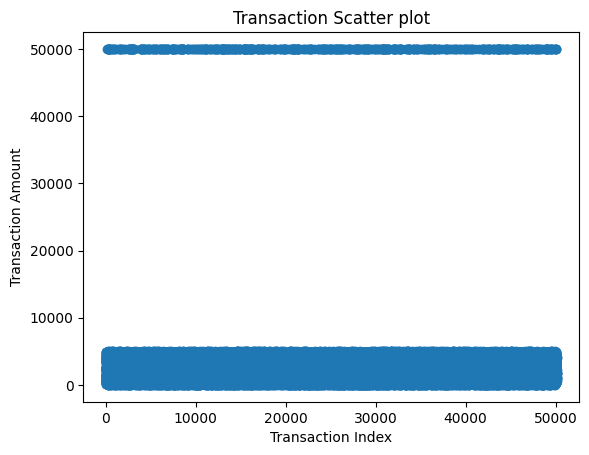

In [16]:
plt.scatter(range(len(df['Transaction_Amount'])), df['Transaction_Amount'])
plt.title('Transaction Scatter plot')
plt.xlabel('Transaction Index')
plt.ylabel('Transaction Amount')
plt.show()

In [17]:
#checkinf null values
df.isnull().sum()

Transaction_ID                         0
User_ID                                0
Transaction_Amount                  2476
Transaction_Type                       0
Time_of_Transaction                 2505
Device_Used                         2437
Location                            2500
Previous_Fraudulent_Transactions       0
Account_Age                            0
Number_of_Transactions_Last_24H        0
Payment_Method                      2428
Fraudulent                             0
dtype: int64

In [18]:
#dropping null values
df.dropna(inplace=True)

In [19]:
df.isnull().sum()

Transaction_ID                      0
User_ID                             0
Transaction_Amount                  0
Transaction_Type                    0
Time_of_Transaction                 0
Device_Used                         0
Location                            0
Previous_Fraudulent_Transactions    0
Account_Age                         0
Number_of_Transactions_Last_24H     0
Payment_Method                      0
Fraudulent                          0
dtype: int64

In [20]:
#shape of the dataframe
df.shape

(38895, 12)

# Feature Engineering

In [21]:

df['Time_of_Transaction'] = pd.to_datetime(df['Time_of_Transaction'])  # Assume string format
df['hour'] = df['Time_of_Transaction'].dt.hour
df['day_of_week'] = df['Time_of_Transaction'].dt.dayofweek
df['Account_Age'] = pd.to_numeric(df['Account_Age'], errors='coerce')  # Ensure numeric

df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent,hour,day_of_week
0,T1,4174,1292.76,ATM Withdrawal,1970-01-01 00:00:00.000000016,Tablet,San Francisco,0,119,13,Debit Card,0,0,3
1,T2,4507,1554.58,ATM Withdrawal,1970-01-01 00:00:00.000000013,Mobile,New York,4,79,3,Credit Card,0,0,3
3,T4,2294,100.10,Bill Payment,1970-01-01 00:00:00.000000015,Desktop,Chicago,4,3,4,UPI,0,0,3
4,T5,2130,1490.50,POS Payment,1970-01-01 00:00:00.000000019,Mobile,San Francisco,2,57,7,Credit Card,0,0,3
5,T6,2095,2372.04,ATM Withdrawal,1970-01-01 00:00:00.000000015,Desktop,Boston,3,96,14,Credit Card,0,0,3


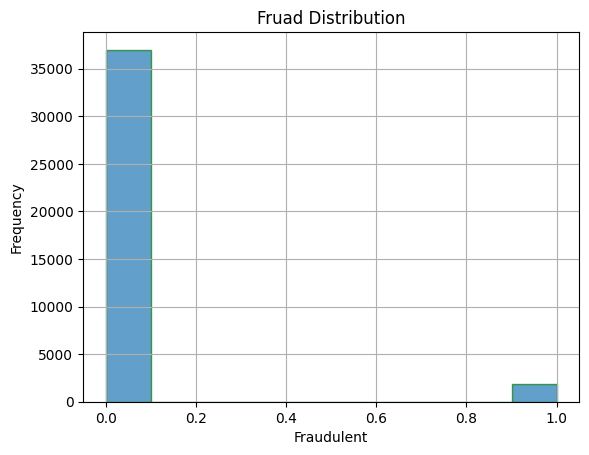

In [22]:
# plotting a histogram to show distribution fro our target value
df['Fraudulent'].hist(bins=10, edgecolor='green', alpha=0.7)
plt.xlabel('Fraudulent')
plt.ylabel('Frequency')
plt.title('Fruad Distribution')
plt.show()


In [23]:
# Defining categorical, numerical columns and target.
cat_col = ['Transaction_Type', 'Device_Used', 'Location', 'Payment_Method']
num_col = ['Previous_Fraudulent_Transaction', 'Number_of_transactions_Last_24h',
            'Account_Age', 'hour', 'day_of_week']

x = df.drop('Fraudulent', axis=1)
y = df['Fraudulent']



In [24]:
#Spliting data into trainng and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.2, random_state=33, stratify=y)

In [25]:
# confirming  categorical and numerical features/ columns 
# TRUE numeric columns only (int/float)
num_features = x_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# ALL string/object columns  
cat_features = x_train.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", num_features)
print("Categorical features:", cat_features)

Numeric features: ['User_ID', 'Transaction_Amount', 'Previous_Fraudulent_Transactions', 'Account_Age', 'Number_of_Transactions_Last_24H']
Categorical features: ['Transaction_ID', 'Transaction_Type', 'Device_Used', 'Location', 'Payment_Method']


# Creating preprocessing pipeline

In [26]:
preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_features), ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
]
    
)

# Full Pipeline

In [27]:
full_pipe = Pipeline([
    ('prepo', preprocess), ('rfc', RandomForestClassifier(n_estimators=150, class_weight='balanced',
                                                                                             random_state=33))
  ]
)

In [28]:
#Train model 
full_pipe.fit(x_train, y_train)

Pipeline(steps=[('prepo',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['User_ID',
                                                   'Transaction_Amount',
                                                   'Previous_Fraudulent_Transactions',
                                                   'Account_Age',
                                                   'Number_of_Transactions_Last_24H']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Transaction_ID',
                                                   'Transaction_Type',
                                                   'Device_Used', 'Location',
                                                   'Payment_Method'])])),
                ('rfc',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=150, random_state=33))])

In [29]:
#Prediction
results = full_pipe.predict(x_test)
print(f'{classification_report(y_test, results)}') #classification Report

y_pred_proba = full_pipe.predict_proba(x_test)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test ROC-AUC: {test_roc_auc:.3f}")

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     29597
           1       0.00      0.00      0.00      1519

    accuracy                           0.95     31116
   macro avg       0.48      0.50      0.49     31116
weighted avg       0.90      0.95      0.93     31116

Test ROC-AUC: 0.508


In [30]:
#save model 
r_model = joblib.dump(full_pipe, 'model_fraud.pickle')

Total features after preprocessing: 7797
Top 5 Most Important Features:
                                 feature  importance
1                num__Transaction_Amount    0.079515
0                           num__User_ID    0.078953
3                       num__Account_Age    0.075568
4   num__Number_of_Transactions_Last_24H    0.058865
2  num__Previous_Fraudulent_Transactions    0.042314


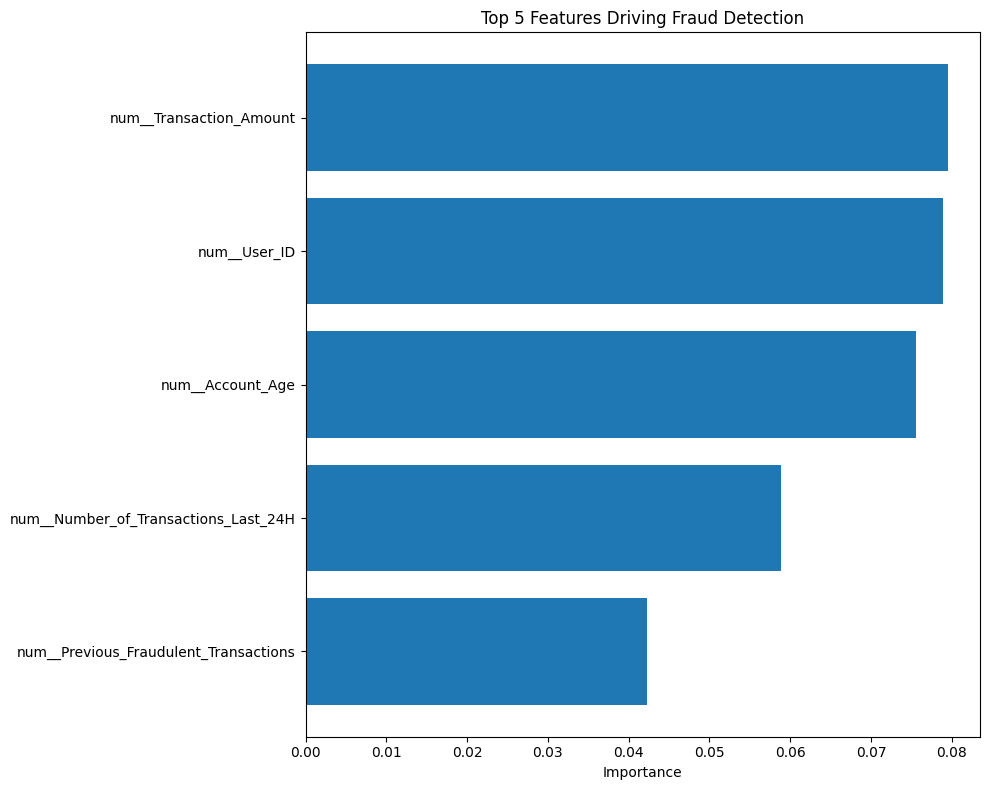

In [31]:
#feature importance from our model

# Get trained Random Forest from pipeline
rf = full_pipe.named_steps['rfc']

# Get feature importances
importances = rf.feature_importances_

# Get feature names (after preprocessing)
feature_names = full_pipe.named_steps['prepo'].get_feature_names_out()
print("Total features after preprocessing:", len(feature_names))

# Combine importances with feature names
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Top 5 Most Important Features:")
print(feature_importance_df.head(5))

# Plot top 5 features
top_features = feature_importance_df.head(5)
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 5 Features Driving Fraud Detection')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



